# GeoPandas Gridding Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook for trying out [GeoPandas](https://geopandas.org/) for gridding species observations. Based on the vector data provided with each occurrence record, the species abundance is proportionally distributed over the grid cells overlapped by the total geometry of the observation, consisting of the GPS accuracy octagon extended with recorded radius.

In this notebook species observation data from NDFF is used. For more information about this data please contact NDFF or visit their website (be aware that it is not fully available in English).

**Data source(s)**:
- ['Nationale Databank Flora en Fauna'](https://ndff.nl) (October 2022). This data is copy protected.

### Import Python Packages

In [3]:
import os

import matplotlib.pyplot as plt

# note that GeoPandas is switching from PyGEOS geometry backend to Shapely 2.0
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gp

import shapely

# from geocube.api.core import make_geocube

### Load sample species observation data
As an example a dataset from the Dutch ['Nationale Databank Flora en Fauna'](https://ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [23]:
# The NDFF datafile to process
#
# Note that these csv files were specifically prepared for this study, and
# other NDFF datasets likely don't have the same columns so will require
# pre-processing first!
#
# Available datasets:
# broedvogels_2016.csv      (observations of nesting birds in 2016)     drop = None
# overigesoorten_2016.csv   (observations of 'other' species in 2016)   drop = ['obs_uri']
# planten_2016.csv          (observations of plants in 2016)            drop = ['obs_uri']

# when working with the S3 bucket:
base_input_file_path = "~/s3/uc2-data"
base_output_file_path = "~/s3/uc2-data"

# when running locally
#base_input_file_path = "../../../local/data"
#base_output_file_path = "../data"

# ----

obs_filename = base_input_file_path + "/ndff-licensed/broedvogels_2016.csv"
obs_crs = "EPSG:28992"

# the columns to drop right away
always_drop_cols_from_source = None
#always_drop_cols_from_source = ['obs_uri']

# ----

# area of interest
aoi_crs  = 'EPSG:32631' # WGS 84 / UTM zone 31N
aoi_xmin =  674900
aoi_xmax =  729800
aoi_ymin = 5832230
aoi_ymax = 5853960

# boundaries for plotting samples
plot_xmin =  702000
plot_xmax =  708000
plot_ymin = 5845000
plot_ymax = 5846000

# the grid to use for data aggregation (using box grid, hex grid doesn't work so well)
aoi_grid_filename = base_input_file_path + "/grids/aoi_grid_box_100m_utm31n.gpkg"
aoi_cell_size = 1000 # meters

# base output path prefix, used for created files
out_prefix = base_output_file_path + "/processed/selectedspecies_2016_100m_"

### Use a Pandas DataFrame for some pre-processing
Do some initial cleaning of the data first. Also fix the geometry data, so it fits GeoPandas expectations.

It would be worthwhile to save the pre-processed data for reuse later. We can then directly specify filter criteria, including a bounding box filter, when reading the data.

In [24]:
# load the data into a regular pandas dataframe
obs_df = pd.read_csv(obs_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    obs_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
obs_df['wkt_excl_crs'] = obs_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
obs_df.drop(columns=['wkt'], inplace=True)
obs_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

# remove non-numeric abundance values
obs_df = obs_df[pd.to_numeric(obs_df['orig_abundance'], errors='coerce').notnull()]
obs_df['orig_abundance'] = obs_df['orig_abundance'].astype(float)

obs_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Krakeend,Anas strepera,2016,territorium,1.0,71,"POLYGON((247282 584478,247280.535533906 584474..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1.0,283,"POLYGON((65405.294923655 436165.134083641,6540..."
2,Zanglijster,Turdus philomelos,2016,territorium,1.0,283,"POLYGON((188642.918478918 344195.927912087,188..."
3,Zanglijster,Turdus philomelos,2016,territorium,1.0,283,"POLYGON((169116.484375 446596.0625,169113.5554..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1.0,283,"POLYGON((127692 427328,127689.071067812 427320..."


### Lift the data into a GeoPandas GeoDataFrame
Create a GeoPandas GeoDataFrame from the regular (non spatial-aware) DataFrame. After that use GeoPandas functionality to transform the data from the Dutch coordinate reference system to the preferred CRS for the area of interest.

In [25]:
# note that we used the pandas dataframe
obs_gs = gp.GeoSeries.from_wkt(obs_df['wkt'])
obs_gdf = gp.GeoDataFrame(obs_df, geometry=obs_gs, crs=obs_crs)

# transform the dataset to the CRS of the area of interest
obs_gdf.to_crs(crs=aoi_crs, inplace=True)
obs_gdf.drop(columns=['wkt'], inplace=True)

obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Krakeend,Anas strepera,2016,territorium,1.0,71,"POLYGON ((751518.337 5905480.782, 751516.991 5..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1.0,283,"POLYGON ((574652.165 5751224.946, 574649.470 5..."
2,Zanglijster,Turdus philomelos,2016,territorium,1.0,283,"POLYGON ((700809.959 5663334.067, 700807.260 5..."
3,Zanglijster,Turdus philomelos,2016,territorium,1.0,283,"POLYGON ((677952.618 5765052.467, 677949.923 5..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1.0,283,"POLYGON ((637182.769 5744436.329, 637180.073 5..."


In [26]:
# save this data in a GIS format
#obs_gdf.to_file(out_prefix + "nl_cleaned.gpkg", driver="GPKG")

### Data selection
Limit the data to that of the area of interest.

In [27]:
# spatially select observations within the area of interest
aoi_obs_gdf = obs_gdf.cx[aoi_xmin:aoi_xmax, aoi_ymin:aoi_ymax]
aoi_obs_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
77,Boomklever,Sitta europaea,2016,territorium,1.0,3,"POLYGON ((696534.968 5839329.095, 696534.699 5..."
177,Boomkruiper,Certhia brachydactyla,2016,territorium,1.0,3,"POLYGON ((696593.972 5839511.176, 696593.703 5..."
244,Zwartkop,Sylvia atricapilla,2016,territorium,1.0,3,"POLYGON ((696559.077 5841648.484, 696558.808 5..."
321,Grauwe gans,Anser anser,2016,territorium,1.0,3,"POLYGON ((708429.841 5850887.999, 708429.572 5..."
352,Boompieper,Anthus trivialis,2016,territorium,1.0,3,"POLYGON ((695002.120 5839142.150, 695001.851 5..."


In [28]:
# save this data in a GIS format for reuse
#aoi_obs_gdf.to_file(out_prefix + "aoi_cleaned.gpkg", driver="GPKG")

### Extend observation polygons with indicated radius

For each observation create a buffer with the recorded radius around the recorded geometry.

In [29]:
aoi_obs_buff_gdf = aoi_obs_gdf.copy()

# add the buffers
aoi_obs_buff_gdf['geometry'] = aoi_obs_gdf.apply(lambda row:
                                                 (row['geometry'].buffer(row['straal'])),
                                                 axis=1)
# add the area of the buffers
aoi_obs_buff_gdf['area_buff'] = aoi_obs_buff_gdf.area

aoi_obs_buff_gdf.head(3)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry,area_buff
77,Boomklever,Sitta europaea,2016,territorium,1.0,3,"POLYGON ((696537.700 5839330.335, 696537.809 5...",49.429436
177,Boomkruiper,Certhia brachydactyla,2016,territorium,1.0,3,"POLYGON ((696596.704 5839512.416, 696596.813 5...",49.429439
244,Zwartkop,Sylvia atricapilla,2016,territorium,1.0,3,"POLYGON ((696561.809 5841649.723, 696561.917 5...",49.429398


<Axes: >

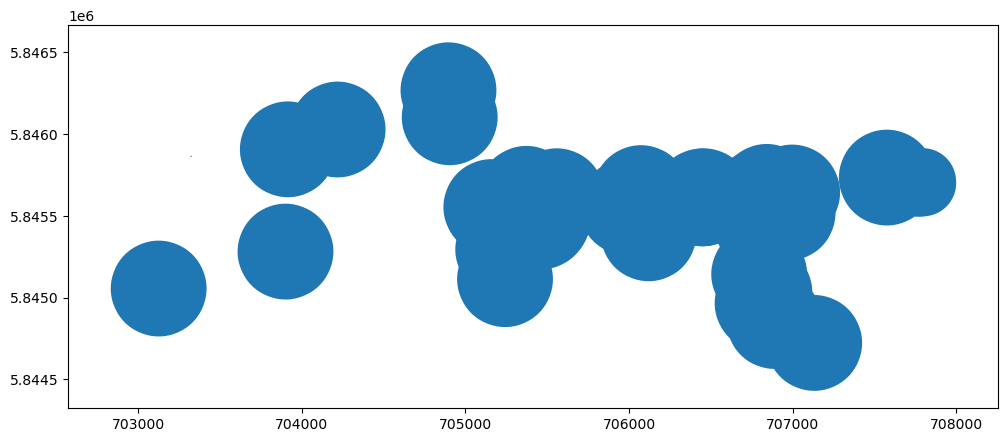

In [30]:
subset = aoi_obs_buff_gdf.cx[plot_xmin:plot_xmax, plot_ymin:plot_ymax]
subset.plot(figsize=(12, 8))

In [31]:
# save this data in a GIS format for reuse
#aoi_obs_buff_gdf.to_file(out_prefix + "aoi_cleaned_buffered.gpkg", driver="GPKG")

### Create a GeoDataFrame with a grid
Load (or construct) a grid that covers the extent of the area of interest. This will later be used to aggregate the data into.

In [32]:
grid_gdf = gp.read_file(aoi_grid_filename, driver="GPKG")
grid_gdf = grid_gdf.cx[aoi_xmin:aoi_xmax, aoi_ymin:aoi_ymax]

In [33]:
# total area for the grid
#xmin, ymin, xmax, ymax= aoi_obs_gdf.total_bounds

# how many cells across and down
#n_cells = 200
#cell_size = (xmax - xmin) / n_cells

# create the cells in a loop
#grid_ids = []
#grid_cells = []
#col = 0
#for x0 in np.arange(xmin, xmax + cell_size, cell_size):
#    row = 0
#    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
#        # bounds
#        x1 = x0 - cell_size
#        y1 = y0 + cell_size
#        grid_ids.append(row * n_cells + col)
#        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
#        row = row + 1
#    col = col + 1

#grid_gdf = gp.GeoDataFrame(data={'cell_id': grid_ids, 'geometry': grid_cells}, geometry='geometry', crs=aoi_crs)
#grid_gdf['area_grid'] = grid_gdf.area

In [34]:
#print(f"cell size = {cell_size:.4f} {grid_gdf.crs.axis_info[0].unit_name}")
grid_gdf.head(3)

,id,left,top,right,bottom,geometry
0,1,674900.0,5853960.0,675000.0,5853860.0,"POLYGON ((674900.000 5853960.000, 675000.000 5..."
1,2,674900.0,5853860.0,675000.0,5853760.0,"POLYGON ((674900.000 5853860.000, 675000.000 5..."
2,3,674900.0,5853760.0,675000.0,5853660.0,"POLYGON ((674900.000 5853760.000, 675000.000 5..."


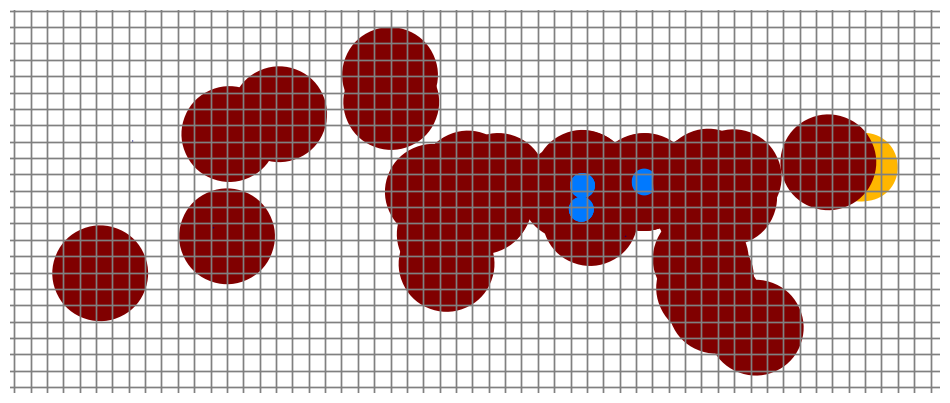

In [35]:
# plot the grid over the observations data (don't try for large grids)
data_selection = aoi_obs_buff_gdf.cx[plot_xmin:plot_xmax, plot_ymin:plot_ymax]
ax = data_selection.plot(markersize=0.5, figsize=(12, 8), column='straal', cmap='jet')
plt.autoscale(False)
grid_selection = grid_gdf.cx[plot_xmin:plot_xmax, plot_ymin:plot_ymax]
grid_gdf.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off");

### Calculate overlap

In [36]:
joined_aoi_gdf = gp.overlay(grid_gdf, aoi_obs_buff_gdf, how='union')
joined_aoi_gdf['area_joined'] = joined_aoi_gdf.area
joined_aoi_gdf.head(5)

,id,left,top,right,bottom,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,area_buff,geometry,area_joined
0,47.0,674900.0,5849360.0,675000.0,5849260.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849260.000, 674986.587 5...",197.634148
1,48.0,674900.0,5849260.0,675000.0,5849160.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849260.000, 675000.000 5...",2857.924937
2,49.0,674900.0,5849160.0,675000.0,5849060.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849160.000, 675000.000 5...",3430.728792
3,50.0,674900.0,5849060.0,675000.0,5848960.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849060.000, 675000.000 5...",799.940011
4,264.0,675000.0,5849460.0,675100.0,5849360.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675100.000 5849360.000, 675056.704 5...",751.977313


In [37]:
# calculate the abundance proportions in each grid cell
joined_aoi_gdf['obs_share'] = (joined_aoi_gdf['area_joined'] / joined_aoi_gdf['area_buff'])
joined_aoi_gdf['abundance_share'] = (joined_aoi_gdf['obs_share'] * joined_aoi_gdf['orig_abundance'])
joined_aoi_gdf.head(5)

,id,left,top,right,bottom,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,area_buff,geometry,area_joined,obs_share,abundance_share
0,47.0,674900.0,5849360.0,675000.0,5849260.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849260.000, 674986.587 5...",197.634148,0.000735,0.000735
1,48.0,674900.0,5849260.0,675000.0,5849160.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849260.000, 675000.000 5...",2857.924937,0.010632,0.010632
2,49.0,674900.0,5849160.0,675000.0,5849060.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849160.000, 675000.000 5...",3430.728792,0.012762,0.012762
3,50.0,674900.0,5849060.0,675000.0,5848960.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675000.000 5849060.000, 675000.000 5...",799.940011,0.002976,0.002976
4,264.0,675000.0,5849460.0,675100.0,5849360.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,283.0,268814.445766,"POLYGON ((675100.000 5849360.000, 675056.704 5...",751.977313,0.002797,0.002797


In [38]:
# save this data in a GIS format for reuse
#joined_aoi_gdf.to_file(out_prefix + "aoi_cleaned_buffered_abundance_share.gpkg", driver="GPKG")

### Merge the observations with the grid
Merge the observations with the grid using a spatial join. Then use a simple count to aggregate the data.

In [39]:
merged_aoi_gdf = gp.sjoin(joined_aoi_gdf, grid_gdf, how='left', predicate='covered_by')
merged_aoi_gdf.head(5)

,id_left,left_left,top_left,right_left,bottom_left,nl_name,sci_name,jaar,countsubject,orig_abundance,...,geometry,area_joined,obs_share,abundance_share,index_right,id_right,left_right,top_right,right_right,bottom_right
0,47.0,674900.0,5849360.0,675000.0,5849260.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,...,"POLYGON ((675000.000 5849260.000, 674986.587 5...",197.634148,0.000735,0.000735,46.0,47.0,674900.0,5849360.0,675000.0,5849260.0
1,48.0,674900.0,5849260.0,675000.0,5849160.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,...,"POLYGON ((675000.000 5849260.000, 675000.000 5...",2857.924937,0.010632,0.010632,47.0,48.0,674900.0,5849260.0,675000.0,5849160.0
2,49.0,674900.0,5849160.0,675000.0,5849060.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,...,"POLYGON ((675000.000 5849160.000, 675000.000 5...",3430.728792,0.012762,0.012762,48.0,49.0,674900.0,5849160.0,675000.0,5849060.0
3,50.0,674900.0,5849060.0,675000.0,5848960.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,...,"POLYGON ((675000.000 5849060.000, 675000.000 5...",799.940011,0.002976,0.002976,49.0,50.0,674900.0,5849060.0,675000.0,5848960.0
4,264.0,675000.0,5849460.0,675100.0,5849360.0,Wielewaal,Oriolus oriolus,2016.0,levend exemplaar,1.0,...,"POLYGON ((675100.000 5849360.000, 675056.704 5...",751.977313,0.002797,0.002797,263.0,264.0,675000.0,5849460.0,675100.0,5849360.0


In [40]:
# make a count column (should count distinct species?)
merged_aoi_gdf['n_obs'] = 1

# aggregate the data
dissolve = merged_aoi_gdf.dissolve(by='index_right', aggfunc={ 'n_obs': 'count', 'abundance_share': 'sum'} )

# put the values into the grid
grid_gdf.loc[dissolve.index, 'abundance_share'] = dissolve['abundance_share'].values

In [41]:
# save this data in a GIS format for reuse
# out_prefix + "aoi_cleaned_buffered_aggregated_abundance_share.tif"
grid_gdf.to_file(out_prefix + "aoi_cleaned_buffered_abundance_share_aggregated.gpkg", driver="GPKG")

### Optional stuff below ...

In [ ]:
grid_gdf['abundance_share'].hist()

In [ ]:
# select a proper vmax for map display (take it from the histogram)
vmax = 10.0

In [ ]:
# plot the grid and the number of observations in each grid cell
sample_gdf = grid_gdf.cx[plot_xmin:plot_xmax, plot_ymin:plot_ymax]

sample_gdf.plot(
    column='abundance_share',
    figsize=(12, 8),
    cmap='YlGn',
    vmax=vmax,
    edgecolor='grey',
    legend=True
);

In [ ]:
# run this cell to get an interactive map of the data (don't try for very small grid cells!)
m1 = grid_gdf.explore(column='abundance_share', cmap='viridis', vmax=vmax, name='Count')
m2 = aoi_obs_buff_gdf.explore(m=m1, color='red', name='Observations')
m2

### Rasterize the grid cell polygons and write to GeoTIFF
One quick way to do this is with the [geocube](https://corteva.github.io/geocube/) package.

Note that this package can also perform some operations when rasterizing data, so in some cases it might be sufficient!

*TODO:*
  - *Fix the shifting of the grid cells (more noticeable with resolution).*
  - *Check how much gridding calculations can be done by geocube directly.*

In [ ]:
# write the file (with CRS)
out_grid = make_geocube(
    vector_data=grid_gdf,
    measurements=['abundance_share'],
    resolution=(-aoi_cell_size, aoi_cell_size)
)
out_grid['abundance_share'].rio.to_raster(out_prefix + "aoi_cleaned_buffered_abundance_share_aggregated_rasterized.tif")

### Extra: GeoPandas Spatial Index

Some interesting details about the R-Tree spatial index used can be found here:
 - [GeoPandas Spatial Index doc](https://geopandas.org/en/stable/docs/reference/sindex.html)
 - [PyGEOS STRTree doc](https://pygeos.readthedocs.io/en/latest/strtree.html)

In [ ]:
# read-only access to the r-tree
r_tree = grid_gdf.sindex
r_tree.size